# Working with Geospatial Data

This section of the tutorial discusses how to use `geopandas` and `shapely` to manipulate geospatial data in Python. If you've never used these libraries before, or are looking for a refresher on how they work, this page is for you!

I recommend reading this notebook using [NBViewer](https://nbviewer.jupyter.org/github/ResidentMario/geoplot/blob/master/notebooks/tutorials/Working%20with%20Geospatial%20Data.ipynb) or, better yet, following along interactively using [Binder](https://mybinder.org/v2/gh/ResidentMario/geoplot/master?filepath=notebooks/tutorials/Working%20with%20Geospatial%20Data.ipynb).

## Coordinate reference systems

The ``GeoDataFrame`` is an augmented version of a ``pandas`` ``DataFrame`` with an attached geometry:

In [2]:
import pandas as pd; pd.set_option('max_columns', 6)  # Unclutter display.
import geopandas as gpd
import geoplot as gplt

# load the example data
nyc_boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
nyc_boroughs

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330385.03697,1.623853e+09,(POLYGON ((-74.05050806403247 40.5664220341608...
1,4,Queens,861038.47930,3.049947e+09,(POLYGON ((-73.83668274106708 40.5949466970158...
2,3,Brooklyn,726568.94634,1.959432e+09,(POLYGON ((-73.8670614947212 40.58208797679338...
3,1,Manhattan,358532.95642,6.364422e+08,(POLYGON ((-74.01092841268033 40.6844914725429...
4,2,Bronx,464517.89055,1.186804e+09,(POLYGON ((-73.89680883223775 40.7958084451597...


Most operations that will work on a `pandas` `DataFrame` will work on a `GeoDataFrame`, but the latter adds a few additional methods and features for dealing with geometry not present in the former. The most obvious of these is the addition of a column for storing geometries, accessible using the `geometry` attribute:

In [3]:
nyc_boroughs.geometry

0    (POLYGON ((-74.05050806403247 40.5664220341608...
1    (POLYGON ((-73.83668274106708 40.5949466970158...
2    (POLYGON ((-73.8670614947212 40.58208797679338...
3    (POLYGON ((-74.01092841268033 40.6844914725429...
4    (POLYGON ((-73.89680883223775 40.7958084451597...
Name: geometry, dtype: object

Whenever you work with novel geospatial data in a `GeoDataFrame`, the first thing you should do is check its **coordinate reference system**.

A [coordinate reference system](https://en.wikipedia.org/wiki/Spatial_reference_system), or CRS, is a system for defining where points in space are. You can extract what CRS your polygons are stored in using the `crs` attribute:

In [9]:
boroughs.crs

{'init': 'epsg:4326'}

In this case `epsg:4326` is the official identifier for what the rest of us more commonly refer to as "longitude and latitude". Most coordinate reference systems have a well-defined EPSG number, which you can look up using the handy [spatialreference.org](http://spatialreference.org/ref/epsg/wgs-84/) website.

Why do coordinate reference systems exist? As an example, the United States Geolocial Service, which maintains extremely high-accuracy maps of the United States, maintains 110 coordinate reference systems, refered to as "state plane coordinate systems", for various portions of the United States. Latitude-longitude uses [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system); state plane coordinate systems use "flat-Earth" [Cartesian coordinate](https://en.wikipedia.org/wiki/Cartesian_coordinate_system). State plane coordinates are therefore much simpler to work with computationally, while remaining accurate enough (within their "zone") for most applications.

For this reason, state plane coordinate systems remain in use throughout government. Similar "speciality coordinate systems" apply in other cases.

For example, here's a sample of data taken from the MapPLUTO dataset released by the City of New York:

In [19]:
nyc_map_pluto_sample = gpd.read_file(gplt.datasets.get_path('nyc_map_pluto_sample'))
nyc_map_pluto_sample

,Borough,Block,Lot,...,Shape_Leng,Shape_Area,geometry
0,MN,1,10,...,12277.824113,7.550340e+06,"POLYGON ((979561.8712409735 191884.2491553128,..."
1,MN,1,101,...,3940.840373,5.018974e+05,"POLYGON ((972382.8255597204 190647.2667211443,..."
2,MN,1,101,...,3940.840373,5.018974e+05,"POLYGON ((972428.8290766329 190679.1751218885,..."
3,MN,1,101,...,3940.840373,5.018974e+05,"POLYGON ((972058.3399882168 190689.2800885588,..."
4,MN,1,201,...,6306.268341,1.148539e+06,"POLYGON ((973154.7118112147 194614.3312935531,..."
5,MN,2,1,...,2721.060649,1.008250e+05,"POLYGON ((980915.0020648837 194319.1402828991,..."
6,MN,2,2,...,2411.869687,8.724423e+04,"POLYGON ((981169.004181549 194678.8213220537, ..."


This data is stored in the Long Island State Plane coordinate reference system ([EPSG 2263](https://www.spatialreference.org/ref/epsg/2263/)).

**Note**: Unfortunately, due to a bug in `geopandas` the CRS on read is set incorrectly to `epsg:4326` and we have to set it to the correct coordinate reference system manually.

In [21]:
nyc_map_pluto_sample.crs = {'init': 'epsg:2263'}
nyc_map_pluto_sample.crs

{'init': 'epsg:2263'}

Depending on the dataset, `crs` may be set to either `epsg:<INT>` or to a raw [`proj4`](https://github.com/OSGeo/PROJ) projection dictionary. For example, if we had read the data from the raw MapPLUTO file instead of from the sample I saved for this tutorial, we would get the following `crs`:

    {'datum': 'NAD83',
     'lat_0': 40.16666666666666,
     'lat_1': 40.66666666666666,
     'lat_2': 41.03333333333333,
     'lon_0': -74,
     'no_defs': True,
     'proj': 'lcc',
     'units': 'us-ft',
     'x_0': 300000,
     'y_0': 0}

If the dataset does not provide any CRS, `geopandas` will assume the data is in lat-long as set `crs` to `epsg:4326`, even if it isn't. It's even possible for a dataset to be wrong about its coordinate reference system.

**Bottom line**: after reading in a dataset, always verify that the dataset coordinate reference system is set to what its documentation it should be set to.

Once you've determined that your coordinates are not latitude-longitude, usually the first thing you want to do is covert to it. `geoplot`, amongst other libraries, expects input to be in latitude-longitude, and will not work correctly witu any other system.

Moving to latitude and longitude is easy. Just convert your data to coordinates using the `geopandas` `to_crs` method:

In [25]:
nyc_map_pluto_sample = nyc_map_pluto_sample.to_crs(epsg=4326)
nyc_map_pluto_sample

,Borough,Block,Lot,...,Shape_Leng,Shape_Area,geometry
0,MN,1,10,...,12277.824113,7.550340e+06,"POLYGON ((-74.0169058260488 40.69335342975063,..."
1,MN,1,101,...,3940.840373,5.018974e+05,POLYGON ((-74.04279194703045 40.68995148413112...
2,MN,1,101,...,3940.840373,5.018974e+05,POLYGON ((-74.04262611856618 40.69003912689961...
3,MN,1,101,...,3940.840373,5.018974e+05,POLYGON ((-74.04396208819837 40.69006636010664...
4,MN,1,201,...,6306.268341,1.148539e+06,"POLYGON ((-74.04001513069795 40.7008411559464,..."
5,MN,2,1,...,2721.060649,1.008250e+05,POLYGON ((-74.01202751677701 40.70003725302833...
6,MN,2,2,...,2411.869687,8.724423e+04,POLYGON ((-74.01111163437272 40.70102458543801...


## Coordinate order

`shapely`, the library `geopandas` uses to store its geometries, uses "modern" longitude-latitude `(x, y)` coordinate order. This differs from the "historical" latitude-longitude `(y, x)` coordinate order. Datasets "in the wild" may be in either format.

There is no way for `geopandas` to know whether a dataset is in one format or the other at load time. Once you have converted your dataset to the right coordinate system, always always always make sure to next check that the geometries are also in the right coordinate order.

This is such a common gotcha that it's made it into the `geoplot` `Quickstart`. It's an easy mistake to make and people are making it constantly!

The fastest way to ensure that coordinates are in the right order is to know what the right x coordinates and y coordinates for your data should be and eyeball it. Alternatively, a foolproof way is to use `mplleaflet` and plot a random landmark from the dataset on a webmap. If the point is where you expect it to be, the coordinate order is correct.

**Note**: you must be running interactively to see the result of the following code cell.

In [30]:
import mplleaflet
gplt.polyplot(nyc_map_pluto_sample.head(1))
mplleaflet.display()

**Note**: this will get easier in forthcoming versions of `geoplot`, which will include webmap tile support.

In [31]:
import shapely

In [32]:
shapely.geometry.LinearRing

shapely.geometry.polygon.LinearRing

## Types of geometries

Every element of the `geometry` column in a `GeoDataFrame` is a `shapely` object. [Shapely](https://github.com/Toblerity/Shapely) is a geometric operations library which is used for manipulating geometries in space, and it's the Python API of choice for working with shape data (under the hood, it uses [GEOS](http://trac.osgeo.org/geos/), which is C++ and ancient).

`shapely` defines just a handful of types of geometries:

* `Point`&mdash;a point.
* `MultiPoint`&mdash;a set of points.
* `LineString`&mdash;a line segment.
* `MultiLineString`&mdash;a collection of lines (e.g. a sequence of connected line segments).
* `LinearRing`&mdash;a closed collection of lines. Basically a polygon with zero-area.
* `Polygon`&mdash;an closed shape along a sequence of points.
* `MultiPolygon`&mdash;a collection of polygons.

You can check the `type` of a geometry using the `type` operator:

In [37]:
type(nyc_boroughs.geometry.iloc[0])

shapely.geometry.multipolygon.MultiPolygon

In [39]:
type(nyc_map_pluto_sample.geometry.iloc[0])

shapely.geometry.polygon.Polygon

## Performing geometric operations

The [`shapely` user manual](https://shapely.readthedocs.io/en/latest/manual.html) provides an extensive list of geometric operations that you can perform using the library: from simple things like translations and transformations to more complex operations like polygon buffering.

You can apply transformations to your geometries in an object-by-object way by using the native `pandas` `map` function on the `geometry` column. For example, here is one way of deconstructing a set of `Polygon` or `MultiPolygon` objects into simplified [convex hulls](https://en.wikipedia.org/wiki/Convex_hull):

CPU times: user 69.2 ms, sys: 2.76 ms, total: 72 ms
Wall time: 71.3 ms


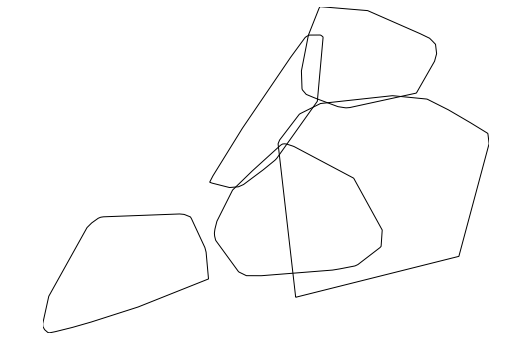

In [45]:
%time gplt.polyplot(nyc_boroughs.geometry.map(lambda shp: shp.convex_hull))

You can perform arbitrarily complex geometric transformations on your shapes this way. However, [most common operations](http://geopandas.org/geometric_manipulations.html) are provided in optimized form as part of the `geopandas` API. Here's a faster way to create convex hulls, for example:

In [46]:
%time nyc_boroughs.convex_hull

CPU times: user 41.4 ms, sys: 1.99 ms, total: 43.4 ms
Wall time: 41.9 ms


0    POLYGON ((-74.24712436215984 40.49611539517034...
1    POLYGON ((-73.94073681665428 40.54182008715522...
2    POLYGON ((-73.98336058039274 40.56952999448672...
3    POLYGON ((-74.02305574749596 40.68291694544512...
4    POLYGON ((-73.87830680057651 40.78535662050845...
dtype: object

It is beyond the scope of this short guide to dive too deeply into geospatial data transformations. Suffice to say that there are many of them, and that you can learn some more about them by consulting the [`geopandas`](http://geopandas.org/) and [`shapely`](https://toblerity.org/shapely/manual.html) documentation.

## Defining your own geometries

In this section of the tutorial, we will focus on one particular aspect of `shapely` which is likely to come up: defining your own geometries.

In the cases above we read a GeoDataFrame straight out of geospatial files: our borough information was stored in the [GeoJSON](http://geojson.org/) format, while our building footprints were a [Shapefile](https://en.wikipedia.org/wiki/Shapefile). What if we have geospatial data embedded in an ordinary `CSV` or `JSON` file, which read into an ordinary `pandas` `DataFrame`?

In [2]:
nyc_collisions_sample = pd.read_csv(gplt.datasets.get_path('nyc_collisions_sample'))
nyc_collisions_sample

,LATITUDE,LONGITUDE,DATE,TIME
0,40.767373,-73.950057,04/16/2016,4:13
1,40.862670,-73.909039,04/16/2016,4:30
2,40.716507,-73.961275,04/16/2016,4:30
3,40.749788,-73.987768,04/16/2016,4:30
4,40.702401,73.960496,04/16/2016,4:50


It is extremely common for datasets containing light geospatial data (e.g. points, maybe line segments, but usually not whole polygons) to be saved in a non-geospatial formats.

In this case can import `shapely` directly, use it to define our own geometries, then initialize a `GeoDataFrame`. The `pandas` `apply` function is the best to do this:

In [3]:
from shapely.geometry import Point

collision_points = nyc_collisions_sample.apply(
    lambda srs: Point(float(srs['LONGITUDE']), float(srs['LATITUDE'])),
    axis='columns'
)
collision_points

0           POINT (-73.950057 40.767373)
1    POINT (-73.90903900000001 40.86267)
2           POINT (-73.961275 40.716507)
3           POINT (-73.987768 40.749788)
4    POINT (73.96049599999999 40.702401)
dtype: object

From there we pass this iterable of geometries to the `geometry` property of the `GeoDataFrame` initializer:

In [6]:
import geopandas as gpd
nyc_collisions_sample_geocoded = gpd.GeoDataFrame(nyc_collisions_sample, geometry=collision_points)
nyc_collisions_sample_geocoded

,LATITUDE,LONGITUDE,DATE,TIME,geometry
0,40.767373,-73.950057,04/16/2016,4:13,POINT (-73.950057 40.767373)
1,40.862670,-73.909039,04/16/2016,4:30,POINT (-73.90903900000001 40.86267)
2,40.716507,-73.961275,04/16/2016,4:30,POINT (-73.961275 40.716507)
3,40.749788,-73.987768,04/16/2016,4:30,POINT (-73.987768 40.749788)
4,40.702401,73.960496,04/16/2016,4:50,POINT (73.96049599999999 40.702401)


In most cases, data with geospatial information provided in a CSV will be point data corresponding with individual coordinates. Sometimes, however, one may wish to define more complex geometry: square areas, for example, and *maybe* even complex polygons. While we won't cover these cases, they're quite similar to the extremely simple point case we've shown here. For further reference on such a task, refer to the `shapely` documentation.

## Joining on existing geometries

Sometimes the necessary geospatial data is elsewhere entirely.

Suppose now that we have information on obesity by state.

In [13]:
obesity = pd.read_csv(gplt.datasets.get_path('obesity_by_state'), sep='\t')
obesity.head()

,State,Percent
0,Alabama,32.4
1,Missouri,30.4
2,Alaska,28.4
3,Montana,24.6
4,Arizona,26.8


We'd like to put this information on a map. But we don't have any geometry!

We will once again have to define a geometry. Except that this time, instead of writing our own, we will need to find data with state shapes, and join that data against this data. In other cases there may be other shapes: police precincts, survey zones, and so on. Here is just such a dataset:

In [17]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
contiguous_usa.head()

,id,adm1_code,State,geometry
0,0,USA-3514,Minnesota,"POLYGON ((-89.59940899999999 48.010274, -89.48..."
1,1,USA-3515,Montana,"POLYGON ((-111.194189 44.561156, -111.291548 4..."
2,2,USA-3516,North Dakota,"POLYGON ((-96.601359 46.351357, -96.5389080000..."
3,4,USA-3518,Idaho,"POLYGON ((-111.049728 44.488163, -111.050245 4..."
4,5,USA-3519,Washington,"POLYGON ((-116.998073 46.33017, -116.906528 46..."


A simple `join` solves the problem:

In [21]:
contiguous_usa.set_index('State').join(obesity.set_index('State')).head()

,id,adm1_code,geometry,Percent
State,,,,
Minnesota,0,USA-3514,"POLYGON ((-89.59940899999999 48.010274, -89.48...",25.5
Montana,1,USA-3515,"POLYGON ((-111.194189 44.561156, -111.291548 4...",24.6
North Dakota,2,USA-3516,"POLYGON ((-96.601359 46.351357, -96.5389080000...",31.0
Idaho,4,USA-3518,"POLYGON ((-111.049728 44.488163, -111.050245 4...",29.6
Washington,5,USA-3519,"POLYGON ((-116.998073 46.33017, -116.906528 46...",27.2


## What to do next

The next section of the tutorial, [Working with Projections](https://nbviewer.jupyter.org/github/ResidentMario/geoplot/blob/master/notebooks/tutorials/Working%20with%20Projections.ipynb), covers another important topic in geospatial visualization.